In [ ]:
%pip install -r requirements.txt

# Imports

In [39]:
import os
import json
from typing import TypedDict, List, Dict, Any
from dotenv import load_dotenv

In [40]:
from langgraph.graph import StateGraph, START, END
from langchain.prompts import PromptTemplate

In [41]:
from langchain.schema import Document
from langgraph.graph import StateGraph, END

In [42]:
from langchain_chroma import Chroma
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings

# Load Config

In [10]:
# Load environment variables from .env file
load_dotenv()

# Access environment variables
azure_api_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")

In [11]:
# Set the environment variables
os.environ['AZURE_OPENAI_API_KEY'] = azure_api_key
os.environ['AZURE_OPENAI_ENDPOINT'] = azure_endpoint

In [13]:
MODEL_NAME = "gpt-4o-mini"
EMBEDDING_MODEL_NAME = "text-embedding-3-small"

# Initialize OpenAI

In [14]:
# Azure OpenAI - GPT-4o or GPT-4o-mini
llm = AzureChatOpenAI(
    deployment_name=MODEL_NAME,
    model_name="gpt-4o",
    temperature=0.3,
    api_version="2024-05-01-preview",
)

In [18]:
embedding_model = AzureOpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)

# Load JSON Data

In [19]:
# Load KB dataset
with open('self_critique_loop_dataset.json') as f:
    kb_data = json.load(f)

In [21]:
# Build records
records = []
for entry in kb_data:
    text = entry["answer_snippet"]
    vector = embedding_model.embed_query(text)  # or embed_documents([text])[0]
    record = {
        "id": entry["doc_id"],
        "vector": vector,
        "metadata": {
            "source": entry["source"],
            "last_updated": entry["last_updated"]
        }
    }
    records.append(record)

print(records[:5])

[{'id': 'KB001', 'vector': [0.01153052132576704, 0.015442011877894402, 0.0634579285979271, 0.016010161489248276, -0.0021214555017650127, 0.0257561095058918, -0.003762169275432825, -0.012244349345564842, 0.019841527566313744, 0.021036099642515182, 0.0502302423119545, 0.012040399014949799, 0.03886725381016731, -0.015252628363668919, 0.02019115909934044, 0.02125461772084236, 0.012506572529673576, 0.04932703077793121, -0.037148237228393555, 0.01016841921955347, 0.08058981597423553, 0.0007229337934404612, 0.02091955579817295, 0.03679860383272171, 0.023075610399246216, -0.028713401407003403, -0.042013924568891525, 0.043121088296175, 0.046355169266462326, -0.0008895545615814626, 0.034088969230651855, -0.037789225578308105, -0.027912164106965065, 0.002414635382592678, 0.01847214251756668, 0.01936078630387783, -0.025610430166125298, -0.026105741038918495, 0.004111799877136946, 0.04335417598485947, 0.02692154422402382, -0.02633882686495781, -0.010197554714977741, 0.037701815366744995, 0.01400707

In [ ]:
# Create Chroma collection (with optional persistence)
vectorstore = Chroma(
    collection_name="kb_index",
    embedding_function=embedding_model,
    persist_directory="./chroma_kb_store"  # optional: persist
)

# Upsert records
vectorstore._collection.add(
    ids=[r["id"] for r in records],
    embeddings=[r["vector"] for r in records],
    metadatas=[r["metadata"] for r in records],
    documents=[kb["answer_snippet"] for kb in kb_data]
)

In [22]:
def save_vectorstore(vectorstore, index_path):
    """
    Save the FAISS vector store to the specified path.
    
    Args:
        vectorstore (FAISS): The vector store to save.
    
    Returns:
        None: If successful, else Exception.
    """
    try:
        vectorstore.save_local(index_path)
    except Exception as e:
        return e

def load_vectorstore(embeddings, index_path, collection_name):
    """
    Load an existing FAISS vector store.
    
    Returns:
        FAISS: Loaded vector store, else Exception.
    """
    try:
        return Chroma(embedding_function=embeddings,persist_directory=index_path,
                      collection_name=collection_name)
    except Exception as e:
        return e

In [23]:
index_path = "./chroma_kb_store"
save_vectorstore(vectorstore, index_path)
print("Vector store created successfully.")

Vector store created successfully.


In [24]:
vectorstore_retriever = vectorstore.as_retriever(search_kwargs={'k': 5})
print("Vector store loaded successfully.")

Vector store loaded successfully.


# LangGraph Functions

## State

In [43]:
class RAGState(TypedDict):
    question: str
    retrieved_docs: List[Document]
    generated_answer: str
    critique: str
    final_docs: List[Document]

## Nodes

In [81]:
def retrieve_kb(state: RAGState) -> RAGState:
    print(f"# 1 - Retrieve Node: Received state: {state}")
    results = vectorstore.similarity_search(state["question"], k=5)
    state["retrieved_docs"] = results
    return state

def generate_answer(state: RAGState) -> RAGState:
    print(f"# 2 - Generate Node: Received state: {state}")
    context = "\n".join([f"- ({doc.metadata['source']}) {doc.page_content}" for doc in state["retrieved_docs"]])
    prompt = f"""
    You are a software best-practices assistant. Answer the following question using the context provided.

    QUESTION: {state["question"]}

    CONTEXT:
    {context}

    Task:
    Based on these snippets, write a concise answer to the user’s question.
    Cite each snippet you use by its doc_id in square brackets (e.g., [KB004]).
    Return only the answer text.
    You are a software best-practices assistant.
    """
    state["generated_answer"] = llm.invoke(prompt)
    return state

def self_critique(state: RAGState) -> RAGState:
    print(f"# 3 - Critique Node: Received state: {state}")
    critique_prompt = f"""
    You are a critical QA assistant. Here is an answer generated for a software best practices question:

    ANSWER:
    {state["generated_answer"]}

    Task:
    Determine if the initial answer fully addresses the question using only these snippets.
    Reply with "COMPLETE" if it's good, or "REFINE" if it needs more detail.
    Return exactly one word.
    """
    critique = str(llm.invoke(critique_prompt)).strip().upper()
    state["critique"] = critique
    return state

def refine_if_needed(state: RAGState) -> RAGState:
    print(f"# 4 - Refine Node: Received state: {state}")
    state["final_docs"] = state["retrieved_docs"]
    if state["critique"] == "REFINE":
        extra = vectorstore.similarity_search(state["question"], k=1, filter=lambda doc: doc not in state["retrieved_docs"])
        state["final_docs"] = state["retrieved_docs"] + extra
        # Re-generate answer
        context = "\n".join([f"- ({doc.metadata['source']}) {doc.page_content}" for doc in state["final_docs"]])
        prompt = f"""
        You are a software best-practices assistant refining your answer. Improve the previous answer using the additional context below.

        QUESTION: {state["question"]}

        CONTEXT:
        {context}

        Task:
        Incorporate this snippet into the answer, covering the missing points.
        Cite any snippet you use by doc_id in square brackets.
        Return only the final refined answer.
        """
        state["generated_answer"] = llm.invoke(prompt)
    return state

## Graph

In [82]:
# --- LangGraph graph ---
graph = StateGraph(RAGState)

graph.add_node("retrieve", retrieve_kb)
graph.add_node("generate", generate_answer)
graph.add_node("critique_node", self_critique)
graph.add_node("refine", refine_if_needed)

graph.add_edge(START, "retrieve")
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", "critique_node")
graph.add_edge("critique_node", "refine")
graph.add_edge("refine", END)

# Compile the graph
app = graph.compile()

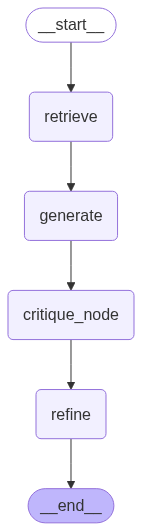

In [83]:
app

# Main Pipeline Code

In [87]:
# --- Minimal interface ---
def run_agentic_rag(question: str):
    state = RAGState(question=question)
    result = app.invoke(state)
    print("\n=== FINAL ANSWER ===")
    print(result["generated_answer"])
    print("\n=== CITED SOURCES ===")
    for doc in result["final_docs"]:
        print(f"{doc.id}: {doc.metadata['source']} (updated {doc.metadata['last_updated']})")

# Test Cases

In [88]:
result["final_docs"]

[Document(id='KB003', metadata={'last_updated': '2024-03-10', 'source': 'caching_guide.md'}, page_content="When addressing caching, it's important to follow well-defined patterns..."),
 Document(id='KB013', metadata={'source': 'caching_guide.md', 'last_updated': '2024-01-10'}, page_content="When addressing caching, it's important to follow well-defined patterns..."),
 Document(id='KB023', metadata={'last_updated': '2024-05-10', 'source': 'caching_guide.md'}, page_content="When addressing caching, it's important to follow well-defined patterns..."),
 Document(id='KB001', metadata={'last_updated': '2024-01-10', 'source': 'debugging_guide.md'}, page_content="When addressing debugging, it's important to follow well-defined patterns..."),
 Document(id='KB011', metadata={'last_updated': '2024-05-10', 'source': 'debugging_guide.md'}, page_content="When addressing debugging, it's important to follow well-defined patterns...")]

In [89]:
# q = input("Enter your software best-practices question: ")
q = "What are best practices for caching?"
run_agentic_rag(q)

# 1 - Retrieve Node: Received state: {'question': 'What are best practices for caching?'}
# 2 - Generate Node: Received state: {'question': 'What are best practices for caching?', 'retrieved_docs': [Document(id='KB003', metadata={'last_updated': '2024-03-10', 'source': 'caching_guide.md'}, page_content="When addressing caching, it's important to follow well-defined patterns..."), Document(id='KB013', metadata={'source': 'caching_guide.md', 'last_updated': '2024-01-10'}, page_content="When addressing caching, it's important to follow well-defined patterns..."), Document(id='KB023', metadata={'last_updated': '2024-05-10', 'source': 'caching_guide.md'}, page_content="When addressing caching, it's important to follow well-defined patterns..."), Document(id='KB002', metadata={'source': 'performance tuning_guide.md', 'last_updated': '2024-02-10'}, page_content="When addressing performance tuning, it's important to follow well-defined patterns..."), Document(id='KB012', metadata={'source': 'p

In [90]:
q = "How do I version my APIs?"
run_agentic_rag(q)

# 1 - Retrieve Node: Received state: {'question': 'How do I version my APIs?'}
# 2 - Generate Node: Received state: {'question': 'How do I version my APIs?', 'retrieved_docs': [Document(id='KB005', metadata={'last_updated': '2024-05-10', 'source': 'API versioning_guide.md'}, page_content="When addressing API versioning, it's important to follow well-defined patterns..."), Document(id='KB015', metadata={'last_updated': '2024-03-10', 'source': 'API versioning_guide.md'}, page_content="When addressing API versioning, it's important to follow well-defined patterns..."), Document(id='KB025', metadata={'source': 'API versioning_guide.md', 'last_updated': '2024-01-10'}, page_content="When addressing API versioning, it's important to follow well-defined patterns..."), Document(id='KB007', metadata={'source': 'CI/CD_guide.md', 'last_updated': '2024-01-10'}, page_content="When addressing CI/CD, it's important to follow well-defined patterns..."), Document(id='KB027', metadata={'last_updated': '2